# Topic of the course

In this practical course, you will explore the behavior of expert mice doing the IBL task. Mice perform the task one time a day, and we call this a behavioral training *session*.

We will explore together some responses of the mice, and then you will select one of these projects:
- Do male mice respond faster than female mice?
- Does training at late time in the day impact on performance?

# Introduction: What data will be used

We will use three [pandas dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):
- `df_subjects` that contains the information on the mouse, which we call subject, for example its name, its date of birth
- `df_sessions` that contains the information on the behavioral sessions made by each subject, for example the start time of the session
- `df_trials` that contains the information for each trials of the sessions, for example the time of the go cue

These dataframes will contain the information of over 300+ sessions, for over 100+ mice.

## Download the datasets
Use this [script](../behavior_course/scripts/data_loading.py) to download the data. Set the `LOCAL_DATA_PATH` to a folder on your machine where you want the data downloaded.

## Technical references
Before starting the analysis, get familiar with :
- [pandas dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)


# Step 1: Explore the data

## Using the visualisation website

You can view the session using the visualisation website, and scrolling down to the session overview page.
You can write a mouse name in the search bar (note that one mouse may have several sessions).

- We use here one [example session](https://viz.internationalbrainlab.org/app?dset=bwm&pid=53ecbf4f-e0d8-4fe6-a852-8b934a37a1c2&tid=0&cid=1399&qc=0) of subject `KS014`

![Viz webpage: session overview](../behavior_course/images/behaviour_overview_PID_53ecbf4f-e0d8-4fe6-a852-8b934a37a1c2.png)

Do you notice that the mouse reaction time increases over the course of the session?

Further down the page, you can observe the timing between events (stim on, first move etc) at each trial; click on the left-image to see a particular trial of interest:

![Viz webpage: trial overview](../behavior_course/images/trial-0153.png)
Look at the first 3 trials, and the last 3 trials during the session. Do you notice any difference?

You can also see the mouse performing the task in real time, and get a sense for how the task enfolds using the panel below ; you can click and drag the center view to explore the environment the mouse is behaving in.

![Viz webpage: setup](../behavior_course/images/behavior_video.png)
Look at the contrast on the screen, and pretend you are doing the task in your mind. Would you have been as fast as the mouse to react and place the stimulus in the center?

## Exploring the dataframes
Below, we will explain:
- How to load the dataframes
- What information is contained in each dataframe
- How to add new information in a dataframe
- How to merge information across dataframes
- How to get summary statistics
- How to generate plots

### Loading the dataframes and navigating their structure
Use the pandas `read_parquet` function to load in the following dataframes:

In [211]:
import pandas as pd
from pathlib import Path

LOCAL_PATH = Path('/Users/gaelle/Documents/Work/Course')

df_sess = pd.read_parquet(LOCAL_PATH.joinpath('sessions.pqt'))
df_subj = pd.read_parquet(LOCAL_PATH.joinpath('subjects.pqt'))
df_trial = pd.read_parquet(LOCAL_PATH.joinpath('trials.pqt'))

Each dataframe contains a different kind of information:
- `df_sess`: each row contains the information on a session, e.g. its start time and date
- `ds_subj`: each row contains the information on a subject, e.g. its name or sex
- `ds_trial`: each row contain the information on a trial (of a particular session), e.g. whether the response was correct or incorrect on that trial

Below we display the first 3 rows for each dataframe:

In [212]:
display(df_sess.head(3))

,eid,subject,lab,task_protocol,date_time,subj_id
0,034e726f-b35f-41e0-8d6c-a22cc32391fb,CSHL045,churchlandlab,_iblrig_tasks_ephysChoiceWorld6.2.5,2020-02-24 14:41:02,b04fd8a4-1ba4-4bc2-9593-238386281a6c
1,dfd8e7df-dc51-4589-b6ca-7baccfeb94b4,CSHL045,churchlandlab,_iblrig_tasks_ephysChoiceWorld6.2.5,2020-02-25 09:53:24,b04fd8a4-1ba4-4bc2-9593-238386281a6c
2,fa704052-147e-46f6-b190-a65b837e605e,CSHL045,churchlandlab,_iblrig_tasks_ephysChoiceWorld6.2.5,2020-02-26 14:48:55,b04fd8a4-1ba4-4bc2-9593-238386281a6c


In [213]:
display(df_subj.head(3))

,subject,subj_id,birth_date,sex,lab
0,CSHL045,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-08-06,M,churchlandlab
1,CSHL047,15f98ab5-20d8-4345-a5de-21912a39575f,2019-08-06,M,churchlandlab
2,CSHL049,9bebfe0b-082e-4d66-aca7-fae29317f708,2019-08-06,M,churchlandlab


In [214]:
display(df_trial.head(3))

,goCueTrigger_times,stimOff_times,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,probabilityLeft,feedback_times,feedbackType,rewardVolume,firstMovement_times,intervals_0,intervals_1,eid,trial_number
0,117.456930,118.805552,117.457586,117.75133,1.0,117.555543,1.000,NaN,0.5,117.751457,1.0,1.5,117.641626,116.695529,119.305634,ae8787b1-4229-4d56-b0c2-566b61a25b77,0
1,127.268840,128.671932,127.269772,127.61124,1.0,127.268639,0.125,NaN,0.5,127.611338,1.0,1.5,127.492626,119.997332,129.171944,ae8787b1-4229-4d56-b0c2-566b61a25b77,1
2,131.702041,133.068359,131.703362,132.00624,1.0,131.701895,1.000,NaN,0.5,132.006365,1.0,1.5,131.802626,129.895043,133.568441,ae8787b1-4229-4d56-b0c2-566b61a25b77,2


### Adding new columns in the dataframe
You can easily add in new columns which are arithmetic combination of already existing columns.
For example, we will compute the reaction time per trial, and add it as a new column in the `df_trial`:

In [215]:
df_trial['reaction_time'] = df_trial['response_times'] - df_trial['goCue_times']

Scroll to the right of the dataframe, and you can see a new column `reaction_time` was added:

In [216]:
display(df_trial.head(3))

,goCueTrigger_times,stimOff_times,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,probabilityLeft,feedback_times,feedbackType,rewardVolume,firstMovement_times,intervals_0,intervals_1,eid,trial_number,reaction_time
0,117.456930,118.805552,117.457586,117.75133,1.0,117.555543,1.000,NaN,0.5,117.751457,1.0,1.5,117.641626,116.695529,119.305634,ae8787b1-4229-4d56-b0c2-566b61a25b77,0,0.293744
1,127.268840,128.671932,127.269772,127.61124,1.0,127.268639,0.125,NaN,0.5,127.611338,1.0,1.5,127.492626,119.997332,129.171944,ae8787b1-4229-4d56-b0c2-566b61a25b77,1,0.341468
2,131.702041,133.068359,131.703362,132.00624,1.0,131.701895,1.000,NaN,0.5,132.006365,1.0,1.5,131.802626,129.895043,133.568441,ae8787b1-4229-4d56-b0c2-566b61a25b77,2,0.302879


### Merging the dataframes
Imagine you need to know for each trial whether the mouse was male or female. This is not an information you readily have in the `df_trial`. But it is information you can retrieve through the other dataframes, in the case of this example:

- Each row in `df_trial` contains the session unique identified `eid`
- Each row in `df_sess` contains the session identified `eid` and the subject identifier `subj_id`
- Each row in `df_subj` contains the subject identifier `subj_id` and `sex`.

You thus can propagate the information contained in the subject table to the trial table, adding the column `sex` for each row of the trial table.

To do such kind of propagation, you need to:
- know which columns are similar across the dataframes
- use the pandas function `merge`

To know which columns are identical, use the `isin` function on columns:
`df1.columns[df1.columns.isin(df2.columns)]`

In [217]:
print(f'Similar column df_trial / df_sess : {df_trial.columns[df_trial.columns.isin(df_sess.columns)]}')
print(f'Similar column df_subj / df_sess : {df_subj.columns[df_subj.columns.isin(df_sess.columns)]}')

Similar column df_trial / df_sess : Index(['eid'], dtype='object')
Similar column df_subj / df_sess : Index(['subject', 'subj_id', 'lab'], dtype='object')


The columns that are similar between dataframes are the following:
- `df_subj` and `df_sess` have the common columns:
    - `subject`
    - `lab`
    - `subj_id`: Note that it is better to use the `subj_id` for merging, as it is the subject's unique identifier. Indeed, a mouse can have the same `subject` name in `lab` A or B.
- `df_sess` and `df_trials` have the common column:
    - `eid`, which is the session's unique identifier.

To merge information across dataframes, use `merge` and specificy the `on` column:

If wanting to merge all columns:
`df1 = df1.merge(df2, on='col_merge')`

If wanting to merge only specific columns:
`df1 = df1.merge(df2[['col_merge', 'col_add_1', 'col_add_2']], on='col_merge')`
--> Notice the use of `[ ]` to generate a list of column names


To propagate the column `sex` in our example, we need to merge two times:

In [218]:
# Merge
df_sess = df_sess.merge(df_subj[['subj_id', 'sex']], on='subj_id') # Add [sex] column into the session based on the subject id
df_trial = df_trial.merge(df_sess[['eid', 'sex']], on='eid') # Add [sex] column into the trial based on the session eid

# Note: We only want to add the 'sex' column to the dataframe, by merging based on the subj_id or eid.
# So we select just the two columns (the one to propagate [sex] and the one to merge on [subj_id] or [eid]) from the dataframe of interest when merging.

Look again at the trials dataframe (towards the far right), there is a new column `sex`:

In [219]:
display(df_trial.head(3))

,goCueTrigger_times,stimOff_times,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,probabilityLeft,feedback_times,feedbackType,rewardVolume,firstMovement_times,intervals_0,intervals_1,eid,trial_number,reaction_time,sex
0,117.456930,118.805552,117.457586,117.75133,1.0,117.555543,1.000,NaN,0.5,117.751457,1.0,1.5,117.641626,116.695529,119.305634,ae8787b1-4229-4d56-b0c2-566b61a25b77,0,0.293744,M
1,127.268840,128.671932,127.269772,127.61124,1.0,127.268639,0.125,NaN,0.5,127.611338,1.0,1.5,127.492626,119.997332,129.171944,ae8787b1-4229-4d56-b0c2-566b61a25b77,1,0.341468,M
2,131.702041,133.068359,131.703362,132.00624,1.0,131.701895,1.000,NaN,0.5,132.006365,1.0,1.5,131.802626,129.895043,133.568441,ae8787b1-4229-4d56-b0c2-566b61a25b77,2,0.302879,M


### Summary statistics of the values in your dataframe

To get a first summary statistics of the data contained in your dataframe, you can use `describe`:

In [220]:
df_subj.describe()

,subject,subj_id,birth_date,sex,lab
count,115,115,115,115,115
unique,115,115,53,2,12
top,CSHL045,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2021-02-02,M,cortexlab
freq,1,1,7,80,17


In [221]:
df_trial.describe()

,goCueTrigger_times,stimOff_times,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,probabilityLeft,feedback_times,feedbackType,rewardVolume,firstMovement_times,intervals_0,intervals_1,trial_number,reaction_time
count,230163.000000,229692.000000,229047.000000,230163.000000,230163.000000,229692.000000,117370.000000,112793.000000,230163.000000,229636.000000,230163.000000,230163.000000,227237.000000,230163.000000,230163.000000,230163.000000,229047.000000
mean,1723.475382,1723.536636,1722.018264,1725.256066,0.004966,1719.962622,0.321309,0.318271,0.506698,1723.290181,0.637978,1.228484,1720.049332,1722.407573,1727.006848,356.844293,1.717720
std,1151.991465,1150.714354,1150.238999,1152.729992,0.997907,1148.683045,0.372139,0.374527,0.278383,1151.648303,0.770056,0.577542,1149.344813,1152.046588,1152.734764,244.695503,5.630646
min,0.604500,9.303933,5.527947,9.324844,-1.000000,5.548545,0.000000,0.000000,0.200000,9.689300,-1.000000,0.000000,6.528642,-20.569910,10.824864,0.000000,-137.816162
25%,785.543736,786.883904,785.287009,786.440143,-1.000000,784.642878,0.062500,0.062500,0.200000,785.785860,1.000000,1.500000,784.477555,784.211235,788.116158,162.000000,0.269435
50%,1544.595477,1544.638077,1543.487844,1546.240157,1.000000,1542.025365,0.125000,0.125000,0.500000,1543.939074,1.000000,1.500000,1540.820952,1543.533531,1547.862391,325.000000,0.370535
75%,2472.608590,2470.858568,2470.237567,2475.245691,1.000000,2466.921022,0.250000,0.250000,0.800000,2471.594228,1.000000,1.500000,2467.300286,2471.595758,2476.952070,504.000000,0.708949
max,6769.916936,7327.883038,6732.631967,6829.918220,1.000000,6732.631133,1.000000,1.000000,0.800000,7327.714589,1.000000,1.500000,6728.982100,6769.380633,6832.418235,1524.000000,60.001248


This tells you for example that there are 115 unique subjects, which you can also get by `unique` applied to the column `subj_id`:

In [222]:
len(df_subj['subj_id'].unique())

115

This also tells you that the longest session has the maximum `trial_number` of 1524, which you can also get by `max`:

In [223]:
df_trial['trial_number'].max()

1524

However, `display` does not give you all statistics possible.
There are many more that you can directly apply to columns of interest, such as `mean`, `median`, `mode`, `variance`, `quantile` etc.
For example, you may be interested to know the 90% percentile of the reaction time distribution:

In [224]:
df_trial['reaction_time'].quantile(q=0.9)

3.443368558525526

Also, `display` does not tell you how many occurrences of one type there is. For example, if you want to know how many male or female mice there are, or how many correct versus incorrect trials there are, use `value_counts`:

In [225]:
df_subj['sex'].value_counts()

M    80
F    35
Name: sex, dtype: int64

In [226]:
df_trial['feedbackType'].value_counts()

 1.0    188501
-1.0     41662
Name: feedbackType, dtype: int64

In order to get summary statistics grouped by a category, use `groupby`. For example, you may want to know the count of feedback type per male/female mice:

In [227]:
df2 = df_trial.groupby('sex')['feedbackType']
df2.value_counts()

sex  feedbackType
F     1.0             46870
     -1.0             11043
M     1.0            141631
     -1.0             30619
Name: feedbackType, dtype: int64

You could also look at the number of correct/incorrect trials per session:

In [228]:
df2 = df_trial.groupby('eid')['feedbackType']
df2.value_counts()

eid                                   feedbackType
02fbb6da-3034-47d6-a61b-7d06c796a830   1.0            507
                                      -1.0            139
03063955-2523-47bd-ae57-f7489dd40f15   1.0            651
                                      -1.0            216
032452e9-1886-449d-9c13-0f192572e19f   1.0            314
                                                     ... 
ff48aa1d-ef30-4903-ac34-8c41b738c1b9  -1.0            143
ff96bfe1-d925-4553-94b5-bf8297adf259   1.0            311
                                      -1.0            115
ffef0311-8ffa-49e3-a857-b3adf6d86e12   1.0            453
                                      -1.0            125
Name: feedbackType, Length: 708, dtype: int64

Once you use `groupby`, you can then use the aggregate method `agg` to get a summary statistic per category. For example, if you want to know the mean reaction time per male/female mice:

In [229]:
df_trial.groupby('sex').agg({'reaction_time': 'mean'})

,reaction_time
sex,
F,1.52260
M,1.78332


### Displaying the values in your dataframe

There are several plots you can use to visualise distributions. We will use:
- Histogram
- Kernel density estimate
- Box plot
- Scatter plot

We will require two libraries: `matplotlib` and `seaborn`. The library `pandas` uses `matplotlib` under the hood, however we need to import it in order to display the legends.


In [230]:
import matplotlib.pyplot as plt  # matplotlib is required to plot the legend
import seaborn as sns


We will now plot the distribution of reaction time (this is across all sessions and all mice). You can use either a histogram plot, or a kernel density estimate plot:

<Axes: >

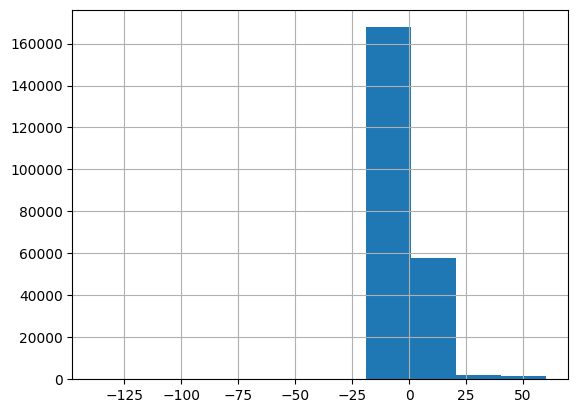

In [231]:
df_trial['reaction_time'].hist()

<Axes: ylabel='Density'>

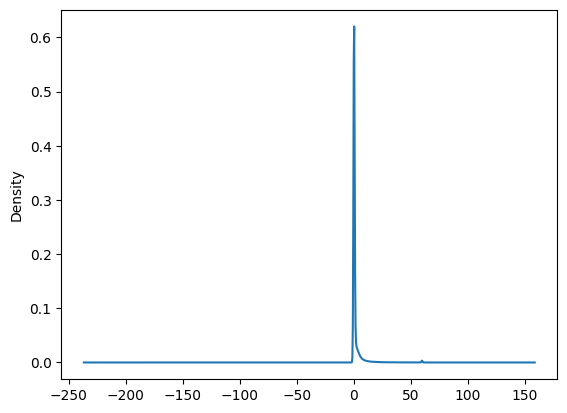

In [232]:
df_trial['reaction_time'].plot(kind='kde')

You can use the plotting functions also on `groupby`, for example if you want to plot the reaction time distribution for male and female mice separately:

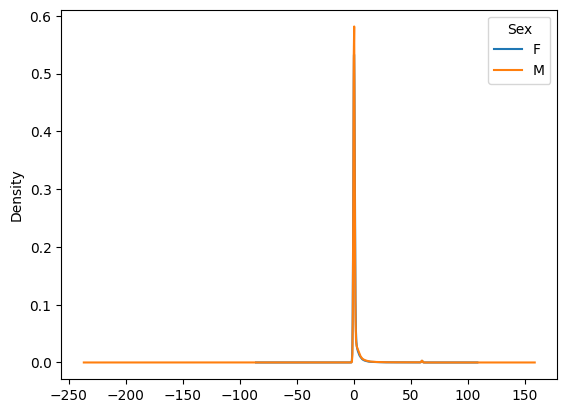

In [233]:
# Plot the histogram of trial numbers for both male and female mice
df_trial.groupby('sex')['reaction_time'].plot(kind='kde')

# Add legends for the curves (sex)
plt.legend(df_trial.groupby('sex').sex.dtype.index.to_list(), title='Sex')

In the plot above, there are two curves but they are hard to distinguish as very similar. We will thus use another kind of plotting to distinguish them better.

Using `box` plot, you do not need to do the `groupby`, as the grouping is declared using the argument `by`:

reaction_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

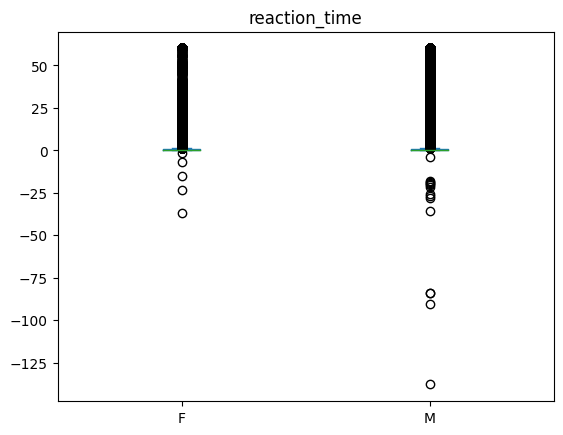

In [234]:
df_trial.plot.box(column="reaction_time", by="sex")

Using the `seaborn` (shortened as `sns`) library, we can generate scatter plot.
This is a useful plot kind, as it shows all the data points. Additionally, you can color data point by a given type.
For example, we plot the reaction time across trial number, and color the data points by the feedback type. This gives a hint that incorrect trials occur throughout the session, however may in proportion be more prevalent towards the end of the session.

<Axes: xlabel='trial_number', ylabel='reaction_time'>

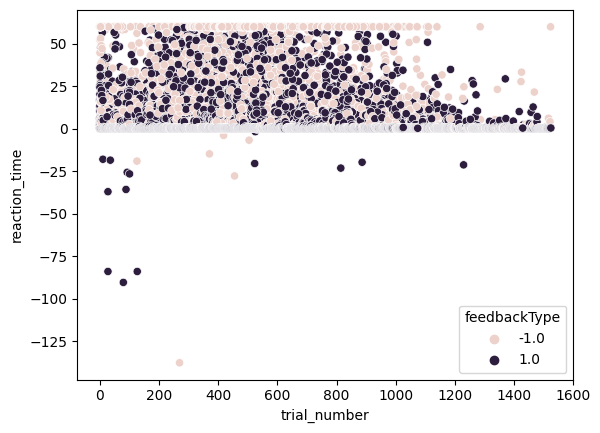

In [235]:
sns.scatterplot(data=df_trial, x='trial_number', y='reaction_time', hue='feedbackType')

### Generate smaller dataframe based on a given condition

You might be interested to work only with certain rows of the dataframe.
You can filter rows based on a column condition via multiple ways. A full tutorial can be found [at this link](https://sparkbyexamples.com/pandas/pandas-filter-by-column-value/), here we will show you two simple ways.

One way is to use the nomenclature:
`df2 = df[df['col'] > value]`  (replace `>` by `==` or `<` as needed)

For example, to get a trial dataframe with rows containing only reaction times above the 75% percentile:

In [236]:
df_trial_rt = df_trial[df_trial['reaction_time'] > df_trial['reaction_time'].quantile(q=0.75)]
print(f'df_trial_rt has {len(df_trial_rt)} rows')

df_trial_rt has 57262 rows


This is a much smaller dataframe than the whole `df_trials`.

Another way is to use `loc`, or `grouby` and `get_group`, for example to create dataframe containing data only for female or male mice:

In [237]:
df_trial_F = df_trial.loc[df_trial['sex'] == 'F']

In [238]:
df_trial_M = df_trial.groupby('sex').get_group('M')

### Perform statistical comparison on the data

In this course, we will mainly want to assess whether 2 distributions are statistically different. For example, we will want co compare the distribution of reaction times of female versus male mice.

For this, we use the library `scipy` which has a `stats` module.
In particular, to compare two distributions we will use the two-sample [Kolmogorov-Smirnov](https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) test [ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html).

In [239]:
from scipy.stats import ks_2samp

ks_2samp(df_trial.groupby('sex').get_group('M')['reaction_time'],
         df_trial.groupby('sex').get_group('F')['reaction_time'])

KstestResult(statistic=0.04689744641485525, pvalue=2.824361208846678e-83, statistic_location=0.19237609995627736, statistic_sign=-1)

Under the null hypothesis the two distributions are identical. If the K-S statistic is small or the p-value is high (greater than the significance level, say 0.05), then we cannot reject the hypothesis that the distributions of the two samples are the same. Conversely, we can reject the null hypothesis if the p-value is low.

# Step 2: Select a project

## Project 1: Do male mice respond faster than female mice?

In this project, we are interested to know whether female mice respond differently than male mice. This is important, because we want to pool data across mice and make generalised conclusion. Therefore, we need to know whether their behavior is indistinguishable. To study this, we will look at the reaction time in trials where the animals responded either correctly or incorrectly.

In this project, you will first:
- Learn how to search the dataframes for male or female subjects
- Learn how to compute reactions times
- Learn how to study reaction times in correct versus incorrect trials
- Explore the trend of the reaction times across a session, by viewing the reaction times across trials, for an example session from either a female or male mice

Then, you will be tasked to:
- Visualise whether the reaction times across trials shows a different trend for female and male mice
- Find a good epoch in the session, and a good metric, to perform the comparison. For example, per mouse, take the first N trials of the session, and compute the median reaction time over it. Compare the median reaction time for male versus female mile

### Loading and visualising the data
Use the pandas `read_parquet` function to load in each dataframe:


In [240]:
import pandas as pd
from pathlib import Path
import numpy as np

LOCAL_PATH = Path('/Users/gaelle/Documents/Work/Course')

# Load the data
df_sess = pd.read_parquet(LOCAL_PATH.joinpath('sessions.pqt'))
df_subj = pd.read_parquet(LOCAL_PATH.joinpath('subjects.pqt'))
df_trial = pd.read_parquet(LOCAL_PATH.joinpath('trials.pqt'))

- `df_sess`: each row contains the information on a session, e.g. its start time and date
- `ds_subj`: each row contains the information on a subject, e.g. its name or sex
- `ds_trial`: each row contain the information on a trial (of a particular session), e.g. whether the response was correct or incorrect on that trial


To know whether a mouse is male or female, look into the column `sex` of the `subjects` dataframe:

In [241]:
print(df_subj.columns)
# We print the unique values from the column sex:
print(np.unique(df_subj['sex']))

Index(['subject', 'subj_id', 'birth_date', 'sex', 'lab'], dtype='object')
['F' 'M']


To compute the reaction time, we will need to use the two variables from the `trials` dataframe:
- the go cue time, found in the colum `goCue_times`
- the response time, found in the column `response_times`

These are the times (in second from the session start) at which the go cue was sent, and a response from the mouse was registered, respectively.

In [242]:
print(df_trial.columns)

df_trial['reaction_time'] = df_trial['response_times'] - df_trial['goCue_times']

Index(['goCueTrigger_times', 'stimOff_times', 'goCue_times', 'response_times',
       'choice', 'stimOn_times', 'contrastLeft', 'contrastRight',
       'probabilityLeft', 'feedback_times', 'feedbackType', 'rewardVolume',
       'firstMovement_times', 'intervals_0', 'intervals_1', 'eid',
       'trial_number'],
      dtype='object')


In [243]:
# Merge
df_sess = df_sess.merge(df_subj[['subject', 'sex']], on='subject')
df_trial_neg_rt = df_trial_neg_rt.merge(df_sess[['eid', 'sex']], on='eid')

print(df_trial_neg_rt.columns)  # Notice we added in the 'sex' column

NameError: name 'df_trial_neg_rt' is not defined

We will now plot the distribution of reaction time (this is across all sessions and all mice). You can use either a histogram plot, or a kernel density estimate plot:

In [ ]:
df_trial['reaction_time'].hist()

In [ ]:
df_trial['reaction_time'].plot(kind='kde')

Did you notice that some reactions times are negative? This can be surprising at first, as this means the mouse made a response before the stimulus was even presented. Let's see how many trials with negative RTs there are:

In [ ]:
df_trial_neg_rt = df_trial[df_trial['reaction_time'] < 0]
print(len(df_trial_neg_rt))

Let's see if negative reaction times occur in both male and female mice.
First, we need to join the trials and subjects table through the sessions table, to later be able to group by the reaction time values by sex type:

In [ ]:
# Merge
df_sess = df_sess.merge(df_subj[['subject', 'sex']], on='subject')
df_trial_neg_rt = df_trial_neg_rt.merge(df_sess[['eid', 'sex']], on='eid')

print(df_trial_neg_rt.columns)  # Notice we added in the 'sex' column

In [ ]:
df_trial_neg_rt.groupby('sex')['reaction_time'].count()

There seems to be more negative reaction time in female mice when displaying just this number, however you have to take into account the proportion of female versus male mice (i.e. we may have many more females than males to begin with).
 - Can you find out how many trials there are for female and male mice?
  - And the proportion of trials done by female compared to male mice?
    - Would this proportion explain the difference with see here with negative reaction time?

Let's see if negative reaction times occur at the end or beginning of the session. We generate the histogram of trial number with negative reaction times:

In [ ]:
df_trial_neg_rt["trial_number"].hist()

This seems pretty evenly spread. However, this may be confounded by the fact that we look at several mice at once.

To see this histogram distribution for either male and female mice on the same plot, we use `groupby`:

In [ ]:
import matplotlib.pyplot as plt
# Note that matplotlib is required to plot the legend

# Plot the histogram of trial numbers for both male and female mice
df_trial_neg_rt.groupby('sex')['trial_number'].plot(kind='hist')

# Add legends for the curves (sex)
plt.legend(df_trial_neg_rt.groupby('sex').sex.dtype.index.to_list(), title='Sex')


You can also use boxplot to reveal the distributions side by side:

In [ ]:
df_trial_neg_rt.plot.box(column="trial_number", by="sex")

- Can you plot the distribution of trial number for negative reaction time per subject?
- How many negative reaction time does each subject do?
- Is there an outlier subject? Can you see if this happens over one, or several session for this outlier?

### Further questions

We have focused on trials with negative reaction times to get you started, however what we really want to know if whether female and male mice respond faster when the reaction time is positive.

- Merge the trials table with the session/subject tables so that it contains the information on `sex` and `subject` name in new columns.
- Create a new trial dataframe with only positive ( `> 0` ) reaction time trials
- Plot the distribution of reaction time for male and female mice using `kde`
-

## Project 2: Does training at late time in the day impact on performance?